In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Параметры настройки подготовки изображений

In [2]:
# Параметры
IMAGE_SIZE = (256, 256)
N_SAMPLES = 200

Загружаем данные из общего датасета(не отобранного вручную)

In [3]:
# Загрузка и подготовка данных
def load_images(folder, label):
    images = []
    labels = []
    files = os.listdir(folder)[:N_SAMPLES]
    for file in files:
        img = Image.open(os.path.join(folder, file)).convert('L').resize(IMAGE_SIZE)
        images.append(np.array(img).flatten())
        labels.append(label)
    return np.array(images), np.array(labels)

cat_images, cat_labels = load_images("data/all/Cat", label=0)
dog_images, dog_labels = load_images("data/all/Dog", label=1)

# Объединяем и перемешиваем
X = np.vstack((cat_images, dog_images))
y = np.concatenate((cat_labels, dog_labels))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучение без PCA

In [4]:
# Обучение на исходных данных
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_original = accuracy_score(y_test, y_pred)
print(f"Accuracy without PCA: {acc_original:.4f}")

Accuracy without PCA: 0.6250


Обучение с PCA, сравнение logreg и destree на разном количестве компонент PCA

c:\Users\Kostya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Kostya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

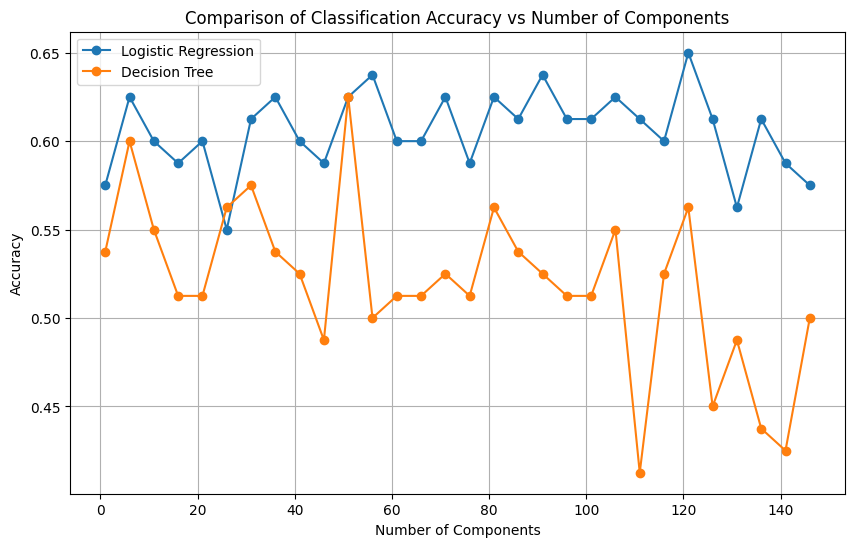

In [5]:
# Применение PCA и анализ зависимости качества от числа компонент
n_components_range = range(1, 151, 5)
accuracy_scores = []
results = {"Logistic Regression": [], "Decision Tree": []}
for n in n_components_range:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Логистическая регрессия
    clf_lr = LogisticRegression(max_iter=1000)
    clf_lr.fit(X_train_pca, y_train)
    y_pred_lr = clf_lr.predict(X_test_pca)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    results["Logistic Regression"].append(acc_lr)

    # Дерево решений
    clf_tree = DecisionTreeClassifier()
    clf_tree.fit(X_train_pca, y_train)
    y_pred_tree = clf_tree.predict(X_test_pca)
    acc_tree = accuracy_score(y_test, y_pred_tree)
    results["Decision Tree"].append(acc_tree)

# Построение сравнительного графика
plt.figure(figsize=(10, 6))
for model, scores in results.items():
    plt.plot(n_components_range, scores, label=model, marker='o')

plt.title('Comparison of Classification Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Строим график объясняемости дисперсий от количества компонент и выводим номер первой компоненты, при добавлении которой объясняемость равна или превышает 90%

Также выводим первые 10 компонент

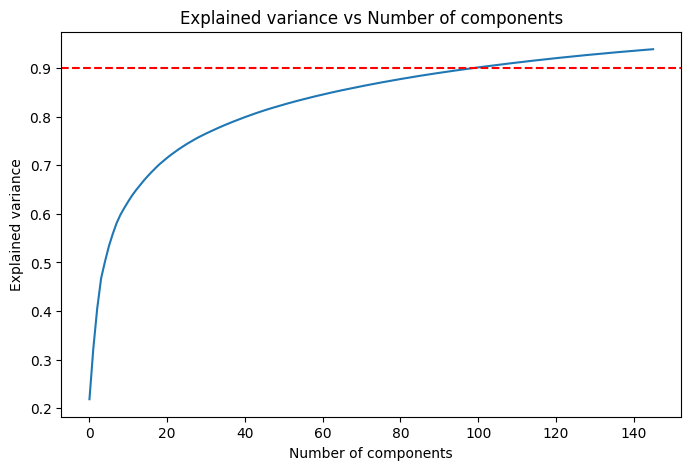

Number of components to explain 90% variance: 100


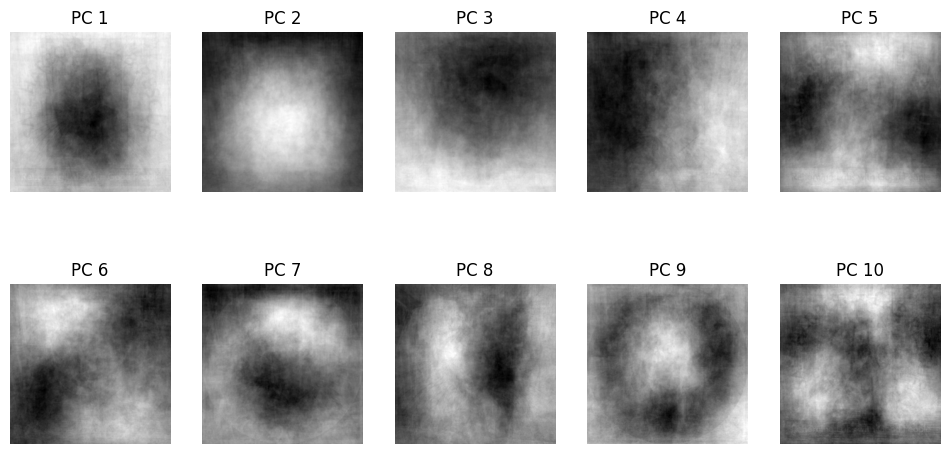

In [6]:
# Анализ дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(explained_variance)
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title("Explained variance vs Number of components")
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

# Количество компонент для 90% дисперсии
n_components_90 = np.argmax(explained_variance >= 0.9) + 1
print(f"Number of components to explain 90% variance: {n_components_90}")

# Визуализация первых 10 главных компонент
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
components = pca.components_[:10]
for i, ax in enumerate(axes.flat):
    ax.imshow(components[i].reshape(IMAGE_SIZE), cmap='gray')
    ax.set_title(f"PC {i + 1}")
    ax.axis('off')
plt.show()

Видим, что в компонентах не очень то и заметны какие-то отличительные признаки кошек или собак(всему виной малое количество изображений и низкое качество датасета)

Проделаем все то же самое, только для отобранных изображений

Параметры настройки подготовки изображений

In [7]:
# Параметры
IMAGE_SIZE = (256, 256)
N_SAMPLES = 200

In [8]:
# Загрузка и подготовка данных
def load_images(folder, label):
    images = []
    labels = []
    files = os.listdir(folder)[:N_SAMPLES]
    for file in files:
        img = Image.open(os.path.join(folder, file)).convert('L').resize(IMAGE_SIZE)
        images.append(np.array(img).flatten())
        labels.append(label)
    return np.array(images), np.array(labels)

cat_images, cat_labels = load_images("data/choosen/Cat", label=0)
dog_images, dog_labels = load_images("data/choosen/Dog", label=1)

# Объединяем и перемешиваем
X = np.vstack((cat_images, dog_images))
y = np.concatenate((cat_labels, dog_labels))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Обучение на исходных данных
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_original = accuracy_score(y_test, y_pred)
print(f"Accuracy without PCA: {acc_original:.4f}")

Accuracy without PCA: 0.6375


c:\Users\Kostya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Kostya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

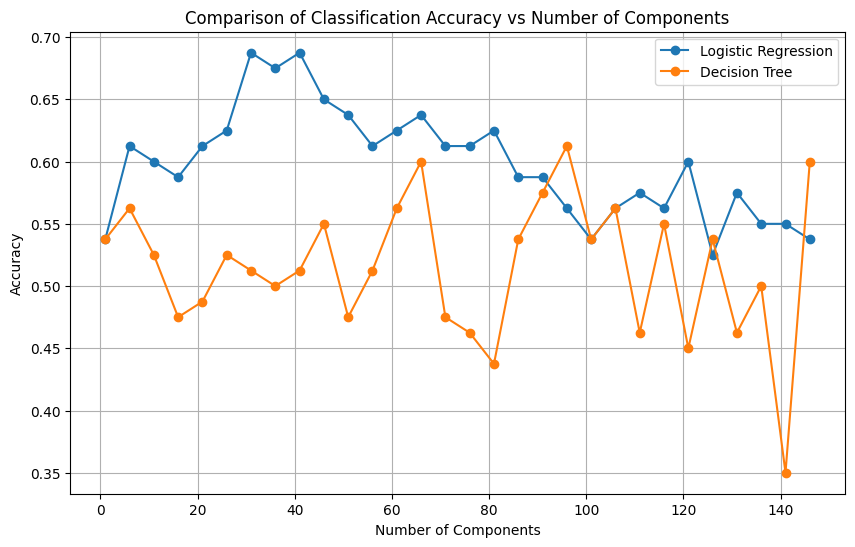

In [10]:
# Применение PCA и анализ зависимости качества от числа компонент
n_components_range = range(1, 151, 5)
accuracy_scores = []
results = {"Logistic Regression": [], "Decision Tree": []}
for n in n_components_range:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Логистическая регрессия
    clf_lr = LogisticRegression(max_iter=1000)
    clf_lr.fit(X_train_pca, y_train)
    y_pred_lr = clf_lr.predict(X_test_pca)
    acc_lr = accuracy_score(y_test, y_pred_lr)
    results["Logistic Regression"].append(acc_lr)

    # Дерево решений
    clf_tree = DecisionTreeClassifier()
    clf_tree.fit(X_train_pca, y_train)
    y_pred_tree = clf_tree.predict(X_test_pca)
    acc_tree = accuracy_score(y_test, y_pred_tree)
    results["Decision Tree"].append(acc_tree)

# Построение сравнительного графика
plt.figure(figsize=(10, 6))
for model, scores in results.items():
    plt.plot(n_components_range, scores, label=model, marker='o')

plt.title('Comparison of Classification Accuracy vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Видим, что качество модели заметно выросло(а это мы всего лишь быстро отобрали не совсем плохие фотографии)
При еще лучшем качестве данных, можно получить куда лучшую модель

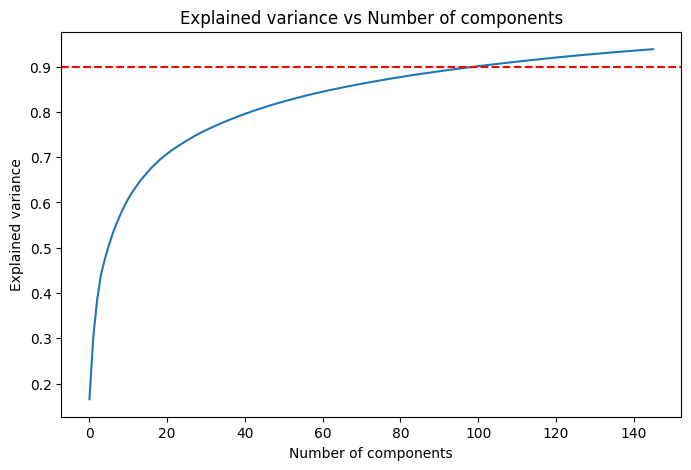

Number of components to explain 90% variance: 101


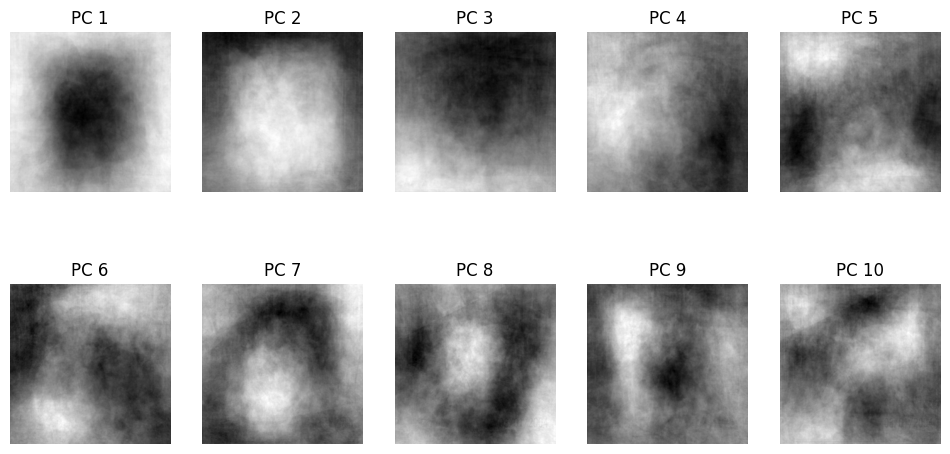

In [12]:
# Анализ дисперсии
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(explained_variance)
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title("Explained variance vs Number of components")
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()

# Количество компонент для 90% дисперсии
n_components_90 = np.argmax(explained_variance >= 0.9) + 1
print(f"Number of components to explain 90% variance: {n_components_90}")

# Визуализация первых 10 главных компонент
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
components = pca.components_[:10]
for i, ax in enumerate(axes.flat):
    ax.imshow(components[i].reshape(IMAGE_SIZE), cmap='gray')
    ax.set_title(f"PC {i + 1}")
    ax.axis('off')
plt.show()

Как видими, количество компонент для объяснения 90% выборки практически не изменилось(даже стало больше на 1)
Изображения первых 10 компанент изменились, но сильно лучше не стали. Они все также похожи на тест Роршаха, хотя в некоторых из них уже можно при желании увидеть мордочку животного